In [1]:
import pandas as pd
import os
import scanpy as sc
import obonet
import networkx

/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx

In [2]:
# Pathway resource base dir
pw_dir = '/home/xlv0877/proj_home/dl/resources'
model_dir = '/home/xlv0877/proj_home/dl/models/mixscale/n_1308/lightning_logs/version_4'

In [3]:
# Read GO obo file
obo_f = os.path.join(pw_dir, 'go-basic.obo')

go = obonet.read_obo(obo_f)

In [4]:
# Read GO mapping
pw = pd.read_csv(os.path.join(pw_dir, 'goa_human.gaf'), sep='\t', comment='!', header=None)
pw.columns = [
    'source', 'id', 'gene_name', 'enable', 'GO', 'GO_REF',
    'state', 'src_pw', 'u', 'pathway_description', 'gene', 'biotype', 'taxon',
    'id2', 'src2', 'u2', 'src_pw2'
]

/tmp/ipykernel_2306094/3018395203.py:2: DtypeWarning: Columns (10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pw = pd.read_csv(os.path.join(pw_dir, 'goa_human.gaf'), sep='\t', comment='!', header=None)


In [5]:
pw_ipi = pw[pw.state=='IPI'].copy()

In [6]:
# Define roots
go_roots = {
    'GO:0008150': 'biological_process',
    'GO:0003674': 'molecular_function',
    'GO:0005575': 'cellular_component'
}

In [7]:
import networkx as nx
from typing import List

def find_immediate_ancestor_below_root(graph, go_id, roots) -> tuple[str, List[str]] | tuple[None, None]:    
    # Find paths from the GO term to each root
    for root_id in roots:
        try:
            # Find all shortest paths from the GO term to the root
            paths = nx.all_shortest_paths(graph.reverse(), source=root_id, target=go_id)
            for path in paths:
                # The immediate ancestor below the root is the second node in the path
                if len(path) > 0:
                    ancestor_names = [graph.nodes[ancestor].get('name', '') for ancestor in path]
                    return roots[root_id], ancestor_names
        except nx.NetworkXNoPath:
            continue
    return None, None

In [8]:
from tqdm.contrib.concurrent import process_map
import pandas as pd

def process_go_term(go_term_id):
    root, ancestors = find_immediate_ancestor_below_root(go, go_term_id, go_roots)
    data = {f'pw_{i}': name for i, name in enumerate(ancestors)}
    data['GO'] = go_term_id
    data['root'] = root
    return data


In [9]:
from tqdm.contrib.concurrent import process_map

# Unique GO terms to process
go_terms = pw_ipi['GO'].unique()

# Process in parallel with a progress bar
results = process_map(process_go_term, go_terms, max_workers=10, chunksize=1)

# Convert the list of dictionaries to a DataFrame
top_lvl_map = pd.DataFrame(results)

  0%|          | 0/1032 [00:00<?, ?it/s]

In [10]:
pw = pw.merge(top_lvl_map, on='GO')

In [11]:
pw.head(2)

,source,id,gene_name,enable,GO,GO_REF,state,src_pw,u,pathway_description,...,pw_1,pw_2,root,pw_3,pw_4,pw_5,pw_6,pw_7,pw_8,pw_9
0,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0003723,GO_REF:0000043,IEA,UniProtKB-KW:KW-0694,F,Diphosphoinositol polyphosphate phosphohydrola...,...,binding,nucleic acid binding,molecular_function,RNA binding,NaN,NaN,NaN,NaN,NaN,NaN
1,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0005515,PMID:33961781,IPI,UniProtKB:Q8NFP7,F,Diphosphoinositol polyphosphate phosphohydrola...,...,binding,protein binding,molecular_function,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
lvl = 0
key = f'pw_{lvl}'
pw_subset = pw[['gene_name', key]].copy()
pw_subset.drop_duplicates(subset='gene_name', keep='first', inplace=True)

In [34]:
# Add control group to pathways
pw_subset = pd.concat([pw_subset, pd.DataFrame({'gene_name': ['control'], key: ['control']})], axis=0)

In [35]:
pw_subset[key].value_counts()

pw_0
molecular_function    16807
cellular_component     7573
biological_process     4139
control                   1
Name: count, dtype: int64

In [36]:
# Read latent
latent = sc.read(os.path.join(model_dir, 'latent.h5ad'))

In [37]:
# Add pathway information to 
latent.obs = latent.obs.merge(pw_subset, left_on='perturbation', right_on='gene_name', how='left')

In [38]:
latent.obs[key].value_counts()

pw_0
molecular_function    193461
biological_process     18214
cellular_component     11519
control                 2000
Name: count, dtype: int64

### gedVI

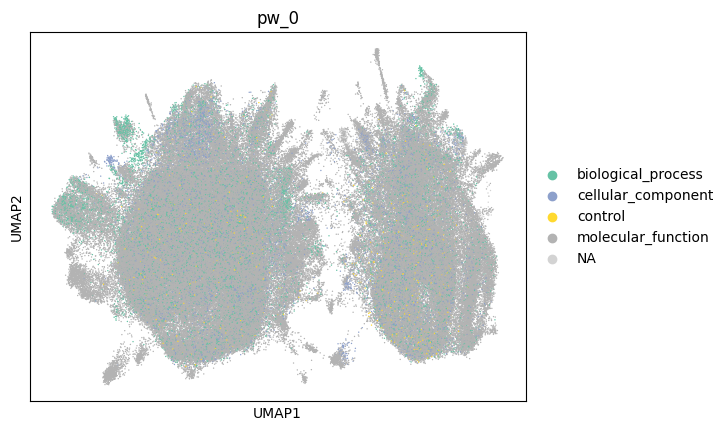

In [41]:
sc.pl.umap(latent, color=key, size=4, palette='Set2')

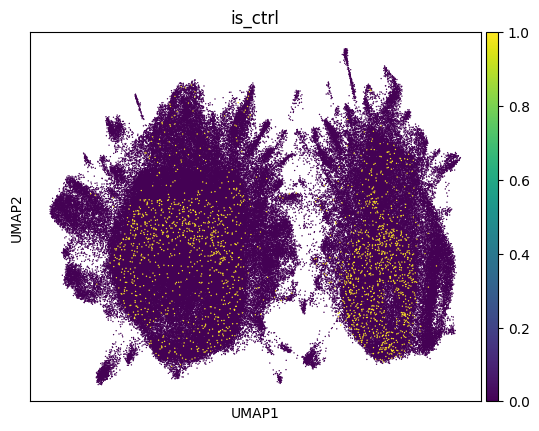

In [42]:
sc.pl.umap(latent, size=4, color='is_ctrl')

### scanVI

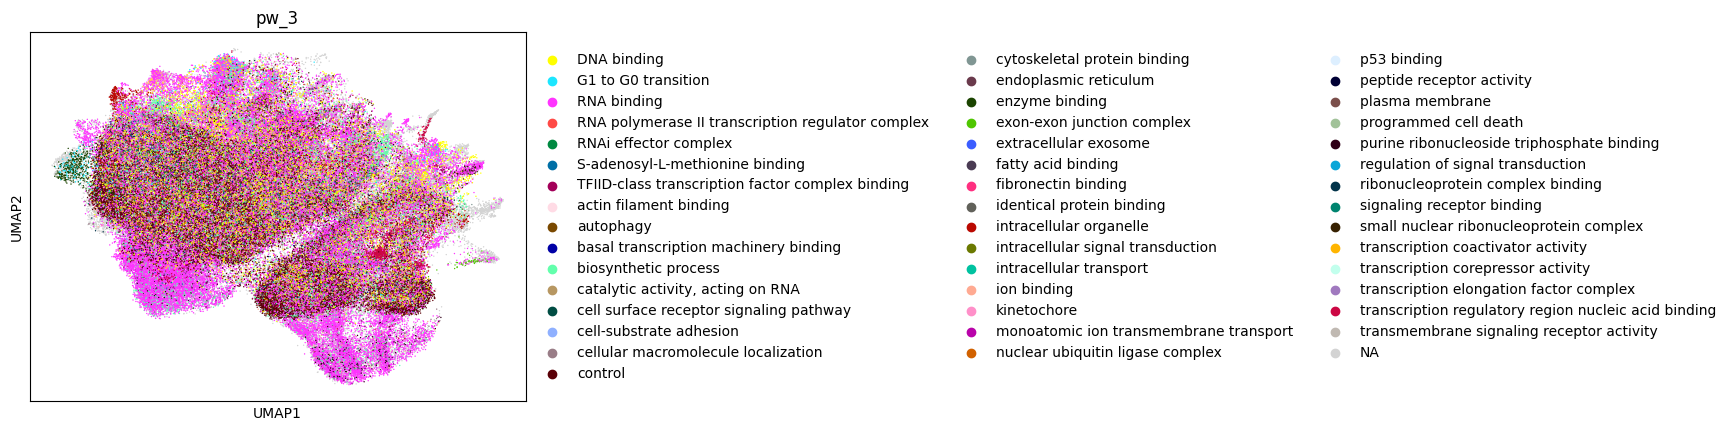

In [153]:
sc.pl.umap(latent, color=key, size=4)

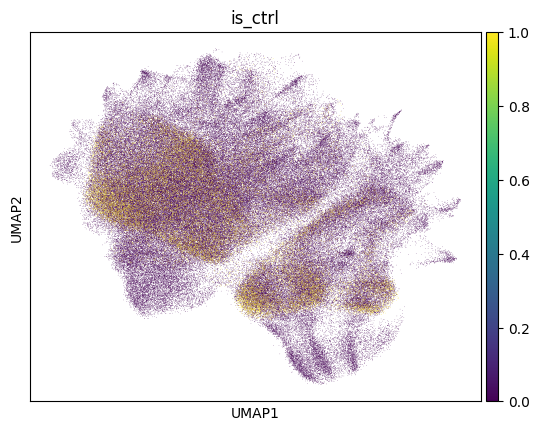

In [148]:
sc.pl.umap(latent, color='is_ctrl')